In [1]:
import pandas as pd
import numpy as np

file_path = './MovieRankingData2024.csv'
data = pd.read_csv(file_path)
movies = list(data.columns[2:])
arr = np.array(data.iloc[:, 2:].values, dtype=float)
A = arr
A[np.isnan(A)] = 0

In [2]:
import numpy as np
from scipy.linalg import solve

def als(A, k=10, lam=0.5, max_iter=400, tol=1e-4, verbose=False):
    m, n = A.shape

    X = np.random.randn(m, k)
    Y = np.random.randn(n, k)

    Omega = {i: np.where(A[i, :] != 0)[0].tolist() for i in range(m)}

    def obj(X, Y):
        """Compute the objective function value."""
        approx = X @ Y.T
        residual = 0.5 * sum((A[i, j] - approx[i, j]) ** 2 for i in range(A.shape[0]) for j in Omega[i])
        regularization = 0.5 * lam * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(Y, 'fro') ** 2)
        return residual + regularization

    prev_objective = obj(X, Y)

    for iteration in range(max_iter):

        for i in range(m):
            Omega_i = Omega[i]
            if len(Omega_i) == 0:
                continue
            A_matrix = Y[Omega_i, :].T @ Y[Omega_i, :] + lam * np.eye(k)
            b_vector = Y[Omega_i, :].T @ A[i, Omega_i]
            X[i, :] = solve(A_matrix, b_vector)

        for j in range(n):
            Omega_j = [i for i in range(len(Omega)) if j in Omega[i]]
            if len(Omega_j) == 0:
                continue
            A_matrix = X[Omega_j, :].T @ X[Omega_j, :] + lam * np.eye(k)
            b_vector = X[Omega_j, :].T @ A[Omega_j, j]
            Y[j, :] = solve(A_matrix, b_vector)

        current_objective = obj(X, Y)

        if verbose:
            print(f"Iteration {iteration + 1}, Objective: {current_objective:.6f}")

        if abs(prev_objective - current_objective) < tol:
            if verbose:
                print(f"Converged at iteration {iteration + 1}")
            break
        prev_objective = current_objective

    return X, Y



In [ ]:
ks = np.arange(1,21)
lams = np.linspace(.1,1,len(ks),endpoint=True)

Ks,Lams = np.meshgrid(ks,lams)
Errs = np.zeros_like(Ks)
for i in range(Ks.shape[0]):
    for j in range(Ks.shape[1]):
        X, Y = als(A, k=Ks[i,j], lam=Lams[i,j], max_iter=400, verbose=False)
        rec = X @ Y.T
        err = np.linalg.norm(A - rec, 'fro')
        Errs[i,j] = err

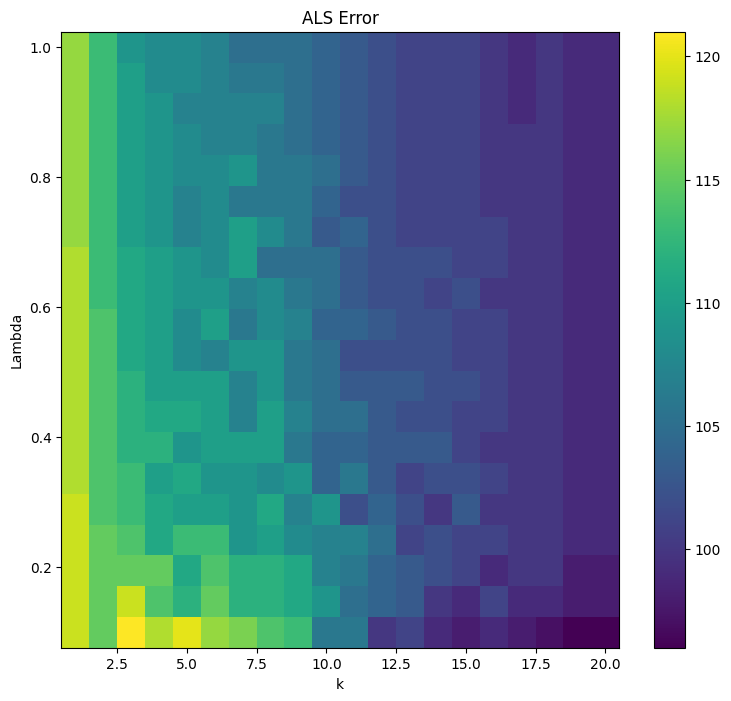

In [189]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 8))
plt.title('ALS Error')
plt.pcolormesh(Ks,Lams,Errs)
plt.xlabel('k')
plt.ylabel('Lambda')
plt.colorbar()
plt.show()

In [137]:
k = Ks[4,10]
lam = Lams[4,10]
X, Y = als(A, k=k, lam=lam, max_iter=400, verbose=True)
rec_als = X@Y.T
err = np.linalg.norm(A - rec_als, 'fro')
print(f"Reconstruction error: {err:.4f}")

Iteration 1, Objective: 1049.074770
Iteration 2, Objective: 361.955338
Iteration 3, Objective: 293.903073
Iteration 4, Objective: 261.399135
Iteration 5, Objective: 241.761554
Iteration 6, Objective: 227.841552
Iteration 7, Objective: 216.982777
Iteration 8, Objective: 208.140650
Iteration 9, Objective: 200.813062
Iteration 10, Objective: 194.667956
Iteration 11, Objective: 189.418213
Iteration 12, Objective: 184.836271
Iteration 13, Objective: 180.759259
Iteration 14, Objective: 177.079408
Iteration 15, Objective: 173.730106
Iteration 16, Objective: 170.666648
Iteration 17, Objective: 167.850463
Iteration 18, Objective: 165.242148
Iteration 19, Objective: 162.800943
Iteration 20, Objective: 160.488883
Iteration 21, Objective: 158.280024
Iteration 22, Objective: 156.170963
Iteration 23, Objective: 154.179383
Iteration 24, Objective: 152.324555
Iteration 25, Objective: 150.610555
Iteration 26, Objective: 149.027685
Iteration 27, Objective: 147.561035
Iteration 28, Objective: 146.195682


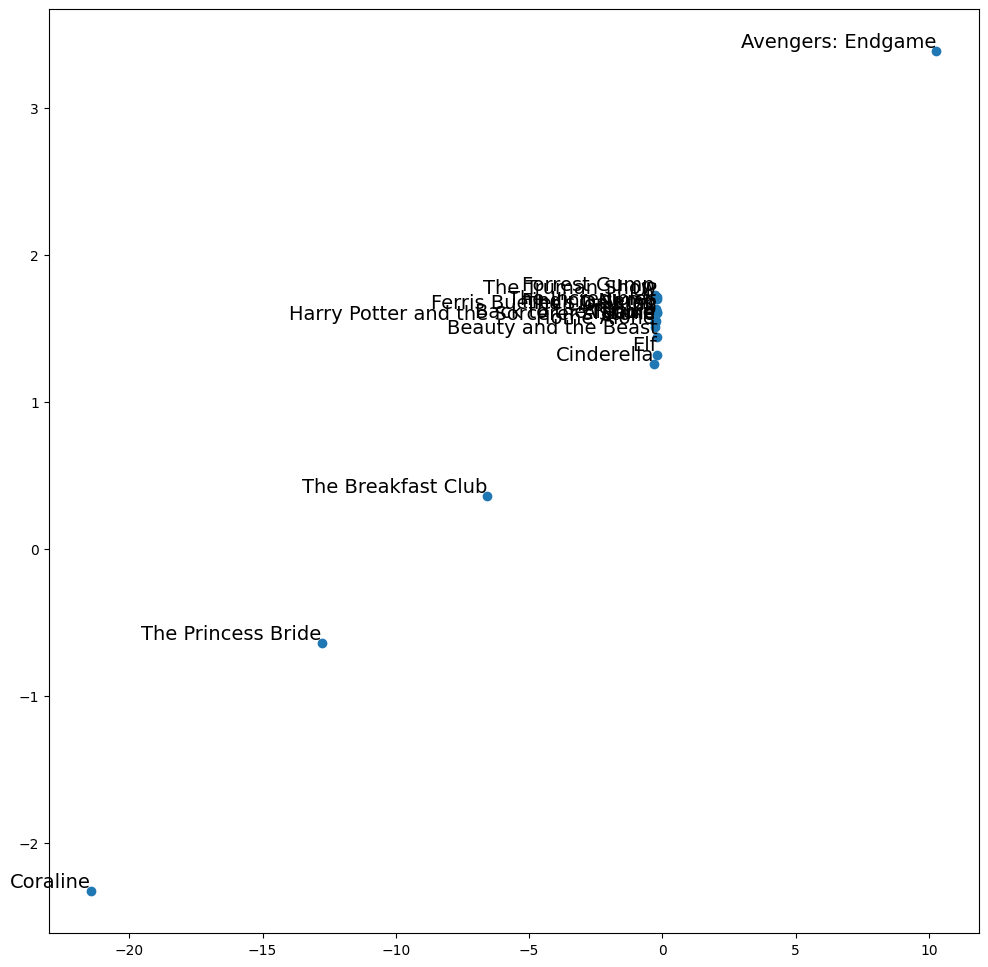

In [23]:
import matplotlib.pyplot as plt

Xu, Yu = als(A, k=2, lam=.0001, max_iter=400, verbose=False)

c = ['blue']*len(Xu)
c[-2] = 'red'

# plt.scatter(Xu[:,0], Xu[:,1], c=c)
plt.figure(figsize=(12, 12))
plt.scatter(Yu[:,0], Yu[:,1])
for i, label in enumerate(movies):
    plt.text(Yu[:,0][i], Yu[:,1][i], label, fontsize=14, ha='right', va='bottom')


In [147]:
len(Xu)

109

In [181]:
import numpy as np
from scipy.linalg import svd



def nuc_norm_complete(A, lam=0.1, max_iter=500, tol=1e-4, verbose=False):
    Omega = [(i, j) for i in range(A.shape[0]) for j in range(A.shape[1]) if A[i, j] != 0]
    M = np.zeros_like(A)
    def _thresh_svd(A, lam):
        U, Sigma, VT = svd(A, full_matrices=False)
        Sigma_thresholded = np.maximum(Sigma - lam, 0)
        return U @ np.diag(Sigma_thresholded) @ VT

    for iteration in range(max_iter):
        P_Omega = np.zeros_like(A)
        for (i, j) in Omega:
            P_Omega[i, j] = A[i, j] - M[i, j]

        M_new = _thresh_svd(M + P_Omega, lam)
        if np.linalg.norm(M_new - M, 'fro') < tol:
            if verbose:
                print(f"Converged at iteration {iteration + 1}")
            break

        M = M_new

        if verbose:
            error = np.linalg.norm(P_Omega, 'fro')
            print(f"Iteration {iteration + 1}, Error: {error:.6f}")

    return M

M = nuc_norm_complete(A, lam=0.9, max_iter=500, verbose=True)

# Evaluate the result
err = np.linalg.norm(A - M, 'fro')
print(f"Reconstruction error: {err:.4f}")


Iteration 1, Error: 147.566197
Iteration 2, Error: 3.296962
Iteration 3, Error: 3.315294
Iteration 4, Error: 3.333850
Iteration 5, Error: 3.352617
Iteration 6, Error: 3.371578
Iteration 7, Error: 3.390712
Iteration 8, Error: 3.409993
Iteration 9, Error: 3.429391
Iteration 10, Error: 3.448872
Iteration 11, Error: 3.468396
Iteration 12, Error: 3.487921
Iteration 13, Error: 3.507398
Iteration 14, Error: 3.526777
Iteration 15, Error: 3.546003
Iteration 16, Error: 3.565023
Iteration 17, Error: 3.583780
Iteration 18, Error: 3.602221
Iteration 19, Error: 3.620295
Iteration 20, Error: 3.637954
Iteration 21, Error: 3.655159
Iteration 22, Error: 3.671873
Iteration 23, Error: 3.688070
Iteration 24, Error: 3.703728
Iteration 25, Error: 3.718834
Iteration 26, Error: 3.733379
Iteration 27, Error: 3.747362
Iteration 28, Error: 3.760784
Iteration 29, Error: 3.773653
Iteration 30, Error: 3.785975
Iteration 31, Error: 3.797764
Iteration 32, Error: 3.809030
Iteration 33, Error: 3.819788
Iteration 34, Err

In [180]:
M[-1,:]

array([2.12644188, 2.99984634, 0.7060363 , 4.98336148, 3.97642866,
       2.57970775, 2.15730736, 2.75663178, 2.13138263, 0.95762317,
       2.48777992, 4.98463085, 1.82913819, 2.04811826, 0.85171472,
       2.04260413, 3.9884088 , 1.61460892, 0.95584652, 1.05555279])

In [183]:
from tabulate import tabulate

als_rec_dan = rec_als[-2, :]
nuc_rec_dan = M[-2, :]
headers = ['Movie', 'True', 'ALS', 'Nuc']
table = []

for ard, nrd, tr, mov in zip(als_rec_dan, nuc_rec_dan, A[-2, :], movies):
    table.append([mov, round(tr, 2), round(ard, 2), round(nrd, 2)])

print(tabulate(table, headers=headers, tablefmt='pretty'))

+---------------------------------------+------+------+------+
|                 Movie                 | True | ALS  | Nuc  |
+---------------------------------------+------+------+------+
|              Home Alone               | 3.0  | 2.96 | 3.02 |
|             The Lion King             | 3.0  | 3.36 | 3.13 |
|          The Princess Bride           | 4.0  | 3.9  | 3.93 |
|                Titanic                | 3.0  | 3.02 | 3.01 |
|         Beauty and the Beast          | 3.0  | 3.17 | 3.08 |
|              Cinderella               | 3.0  | 2.53 | 2.93 |
|                 Shrek                 | 4.0  | 4.01 | 3.92 |
|             Forrest Gump              | 3.0  | 3.35 | 3.1  |
|                Aladdin                | 4.0  | 3.87 | 3.95 |
|       Ferris Bueller's Day Off        | 4.0  | 4.17 | 3.93 |
|             Finding Nemo              | 5.0  | 4.58 | 4.84 |
| Harry Potter and the Sorcerer's Stone | 2.0  | 1.71 | 2.08 |
|          Back to the Future           | 4.0  | 3.86 |

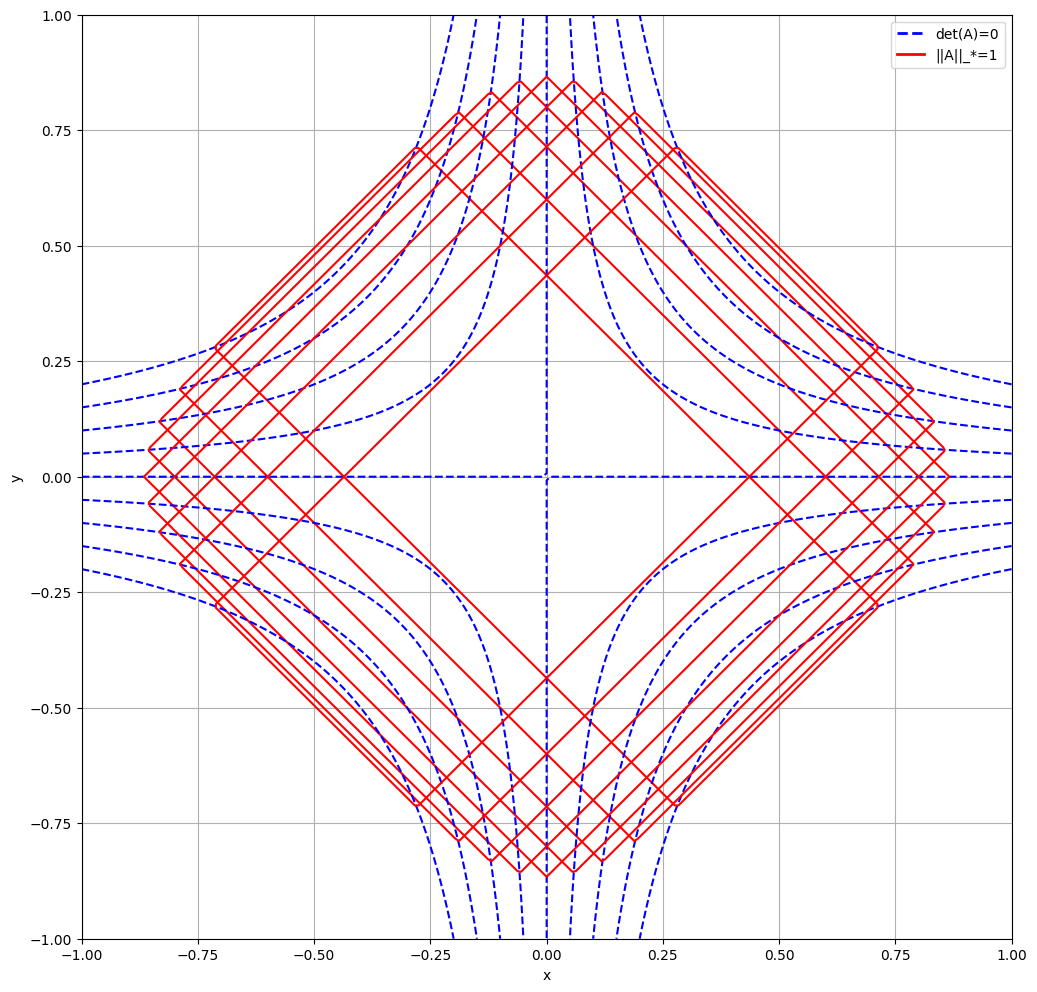

In [185]:
import numpy as np

zr = np.linspace(-.4,.4,9,endpoint=True)
xr = np.linspace(-1,1,255,endpoint=True)
yr = np.linspace(-1,1,255,endpoint=True)
X, Y = np.meshgrid(xr, yr)
detsz = []
normsz = []
for z in zr:
    dets = np.zeros_like(X)
    norms = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):

            A = np.array([[.5,X[i,j]],[Y[i,j],z]])
            w = np.linalg.det(A)
            dets[i,j] = w
            norms[i,j] = np.linalg.norm(A,ord='nuc')
    detsz.append(dets)
    normsz.append(norms)


import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for i in range(len(zr)):
    plt.contour(X,Y,detsz[i], levels=[0], colors='b', linestyles='dashed')
    plt.contour(X,Y,normsz[i], levels=[1], colors='r', linestyles='solid')

custom_lines = [
    plt.Line2D([0], [0], color='b', lw=2, linestyle='dashed', label='det(A)=0'),
    plt.Line2D([0], [0], color='r', lw=2, linestyle='solid', label='||A||_*=1')
]
plt.legend(handles=custom_lines)


plt.xlabel('x')
plt.ylabel('y')
# plt.legend()
plt.grid()
plt.show()